In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.io import loadmat
import visionloader as vl
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
import os
import src.fitting as fitting
import src.multielec_utils as mutils
import src.old_labview_data_reader as oldlv
from mpl_toolkits.mplot3d import Axes3D
import cvxpy as cp
from scipy.optimize import minimize
import statsmodels.api as sm

%load_ext autoreload
%autoreload 2
%matplotlib notebook

# Load in triplet stim elecResps and amplitudes

In [2]:
# Current values in uA

Ivals = np.array([0.10053543, 0.11310236, 0.11938583, 0.13195276, 0.14451969,                        
                       0.16337008, 0.17593701, 0.1947874 , 0.2136378 , 0.23877165,
                       0.25762205, 0.2780315 , 0.30330709, 0.35385827, 0.37913386,
                       0.42968504, 0.45496063, 0.50551181, 0.55606299, 0.60661417,
                       0.68244094, 0.73299213, 0.8088189 , 0.88464567, 0.98574803,
                       1.10433071, 1.20472441, 1.30511811, 1.40551181, 1.60629921,
                       1.70669291, 1.90748031, 2.10826772, 2.30905512, 2.50984252,
                       2.81102362, 3.11220472, 3.41338583, 3.71456693, 4.1161])

In [22]:
ANALYSIS_BASE = "/Volumes/Analysis"
gsort_path = "/Volumes/Scratch/Users/praful/triplet_gsort_v2_30um_raphe-affinity_cosine"
gsort_path_1elec = "/Volumes/Scratch/Users/praful/single_gsort_v2_30um_raphe-affinity_cosine"

In [23]:
dataset = "2020-10-18-0"
estim = "data003/data003-all"
estim_1elec = "data001"
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim)

In [24]:
wnoise = "kilosort_data000/data000"
vis_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)
vis_datarun = wnoise.split('/')[-1]
vcd = vl.load_vision_data(
    vis_datapath,
    vis_datarun,
    include_neurons=True,
    include_ei=True,
    include_params=True,
    include_noise=True,
)

coords = vcd.get_electrode_map()

In [58]:
clusters_t = 10
clusters_nt = 10
negll_thr = 0.95

In [59]:
p = 3
targets = np.array([81])
nontargets = np.array([72])

p_thr = 2/19
p_upper = 1
random_state = 0

<IPython.core.display.Javascript object>


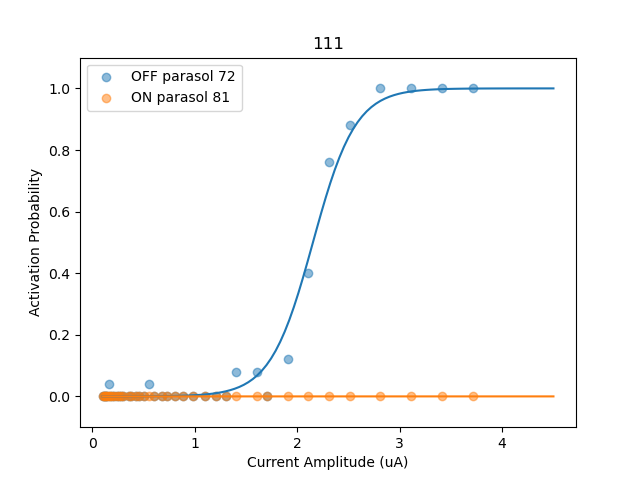

<IPython.core.display.Javascript object>


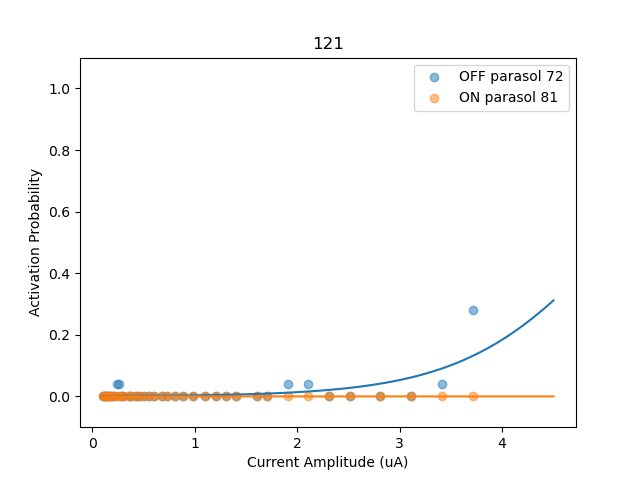

<IPython.core.display.Javascript object>


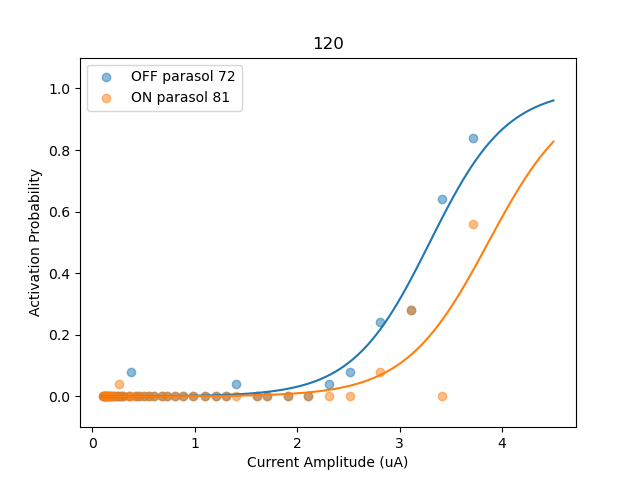

In [60]:
triplet_elecs = mutils.get_stim_elecs_newlv(electrical_path, p)
all_cells = np.sort(np.concatenate((targets, nontargets)).astype(int))
all_signals = []

for elec in triplet_elecs:
    filepath_1elec = os.path.join(gsort_path_1elec, dataset, estim_1elec, wnoise, "p" + str(elec))
    plt.figure()
    plt.title(str(elec))
    plt.ylim(-0.1, 1.1)
    plt.ylabel('Activation Probability')
    plt.xlabel('Current Amplitude (uA)')
    
    cell_signals = []
    for cell in all_cells:
        k = 0
        probs = []
        trials = []
        signals = []
        while True:
            try:
                with open(os.path.join(filepath_1elec, "gsort_single_v2_n" + str(cell) + "_p" + str(elec) + "_k" + str(k) + ".pkl"), "rb") as f:
                    prob_dict = pickle.load(f)
                    probs.append(prob_dict["cosine_prob"][0])
                    trials.append(prob_dict["num_trials"])
                    electrode_list = prob_dict["electrode_list"]
                                        
                signal = oldlv.get_oldlabview_pp_data(os.path.join(ANALYSIS_BASE, dataset, estim_1elec), 
                                                      elec, k)[:,electrode_list,:55]
                signals.append(signal)
            except:
                break
            
            k += 1
        
        cell_signals.append(signals)
        trials = np.array(trials, dtype=int)
        probs = np.array(probs)

        if len(probs) > 0:    
            probs = fitting.disambiguate_sigmoid(probs, spont_limit = 0.15, noise_limit = 0.1)

            X_bin, y_bin = fitting.convertToBinaryClassifier(probs, trials, Ivals[:k].reshape(-1, 1))
        
            results = minimize(fitting.negLL, x0=np.array([-1, 1]), args=(X_bin, y_bin, False, 'none'))
        
            currs = np.linspace(0.1, 4.5, 100)
            plt.plot(currs, fitting.fsigmoid(sm.add_constant(currs.reshape(-1, 1)), results.x))
            plt.scatter(Ivals[:k], probs, alpha=0.5, 
                        label=vcd.get_cell_type_for_cell(cell) + ' ' + str(cell))
    
    plt.legend()
    
    all_signals.append(cell_signals)
        

<IPython.core.display.Javascript object>


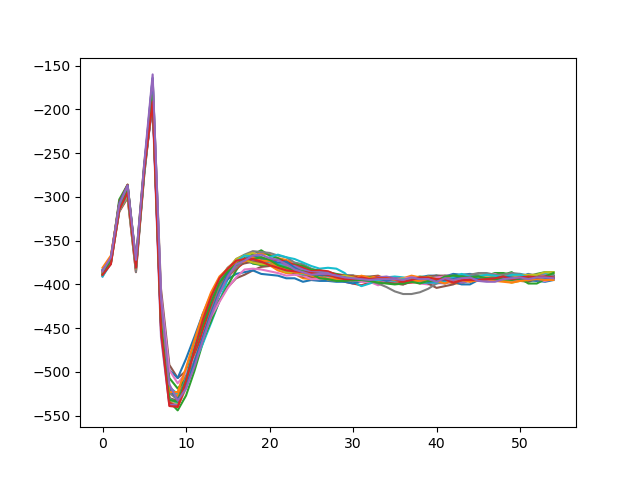

In [61]:
plt.figure()
plt.plot(all_signals[2][0][-1][:, 0, :].T);

In [62]:
def getWeights(p, n, n_clusters, nll_thr, points_per_cluster=30, selec_vec=np.zeros(3), show_clusters=False):
    filepath = os.path.join(gsort_path, 
                            dataset, estim, wnoise, "p" + str(p))

    amplitudes = mutils.get_stim_amps_newlv(electrical_path, p)
    num_pts = len(amplitudes)

    triplet_probs = np.zeros(num_pts)
    trials = np.zeros(num_pts, dtype=int)
    for k in range(num_pts):
        with open(os.path.join(filepath, "gsort_tri_v2_n" + str(n) + "_p" + str(p) + "_k" + str(k) + ".pkl"), "rb") as f:
            prob_dict = pickle.load(f)
            triplet_probs[k] = prob_dict["cosine_prob"][0]
            trials[k] = prob_dict["num_trials"]

    good_inds = np.where((triplet_probs > p_thr) & (triplet_probs < p_upper))[0]

    y = triplet_probs[good_inds]
    X = amplitudes[good_inds]

    fig = plt.figure()
    fig.clear()
    ax = Axes3D(fig)
    plt.xlabel(r'$I_1$')
    plt.ylabel(r'$I_2$')
    ax.set_zlabel(r'$I_3$')

    scat = ax.scatter(amplitudes[:, 0][good_inds], 
                amplitudes[:, 1][good_inds],
                amplitudes[:, 2][good_inds], marker='o', s=20, c=triplet_probs[good_inds], alpha=0.8)
    if np.any(selec_vec != 0):
        ax.scatter(selec_vec[0], selec_vec[1], selec_vec[2], c='tab:red', marker='*', s=100)

    clb = plt.colorbar(scat)
    plt.show()

    clustering = SpectralClustering(n_clusters=n_clusters, 
                                    assign_labels='discretize',
                                    affinity='nearest_neighbors', 
                                    random_state=random_state).fit(X)

    pp_weights = []
    for i in range(n_clusters):
        inds = np.where(clustering.labels_ == i)[0]

        if show_clusters:
            fig = plt.figure()
            fig.clear()
            ax = Axes3D(fig)
            plt.xlabel(r'$I_1$')
            plt.ylabel(r'$I_2$')
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$')

            scat = ax.scatter(X[inds, 0], 
                        X[inds, 1],
                        X[inds, 2], marker='o', s=20, c=y[inds], alpha=0.8)

            clb = plt.colorbar(scat)
            plt.show()

        X_cluster = X[inds]
        y_cluster = y[inds]
        trials_cluster = trials[good_inds][inds]
        
        X_bin, y_bin = fitting.convertToBinaryClassifier(y_cluster, trials_cluster, X_cluster)
        
        results = minimize(fitting.negLL, x0=np.array([-1, 1, 1, 1]), args=(X_bin, y_bin, False, 'none'))
        print(results.x)
        
        nll_MLE = fitting.negLL(results.x, X_bin, y_bin, False, 'none')        
        print(nll_MLE)
        
        if show_clusters:
            plt.figure()
            plt.scatter(fitting.fsigmoid(sm.add_constant(X_cluster, has_constant='add'), results.x), y_cluster)
            plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), c='k', linestyle='--')

        if nll_MLE < nll_thr and results.x[0] < 0 and len(inds) > points_per_cluster:
            pp_weights.append(results.x)

    return np.array(pp_weights), amplitudes, triplet_probs

OFF parasol


<IPython.core.display.Javascript object>


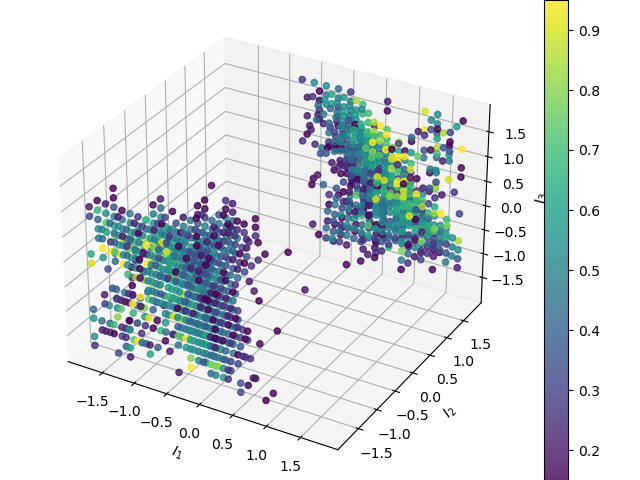

/tmp/ipykernel_9008/354451011.py:23: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
/Volumes/Lab/Development/miniconda-peggyo/envs/pvasi39/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<IPython.core.display.Javascript object>


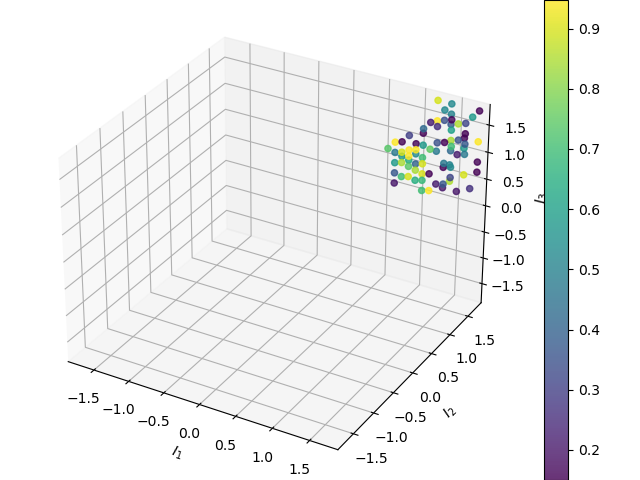

[ 2.30320794 -1.21764343 -0.28457971 -0.09065462]
0.9762941173646846


/tmp/ipykernel_9008/354451011.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


<IPython.core.display.Javascript object>


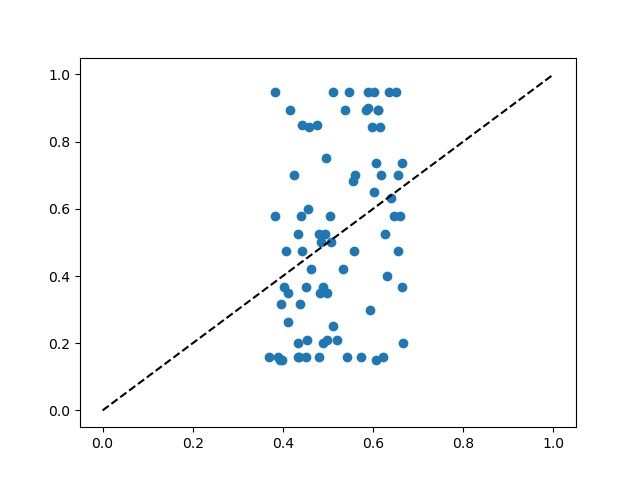

<IPython.core.display.Javascript object>


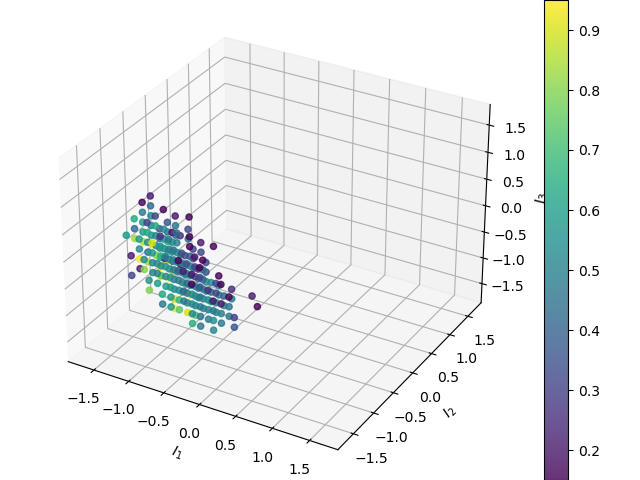

[-4.91219967 -2.22459139 -1.6116693  -1.62300892]
0.9437529675594162


/tmp/ipykernel_9008/354451011.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


<IPython.core.display.Javascript object>


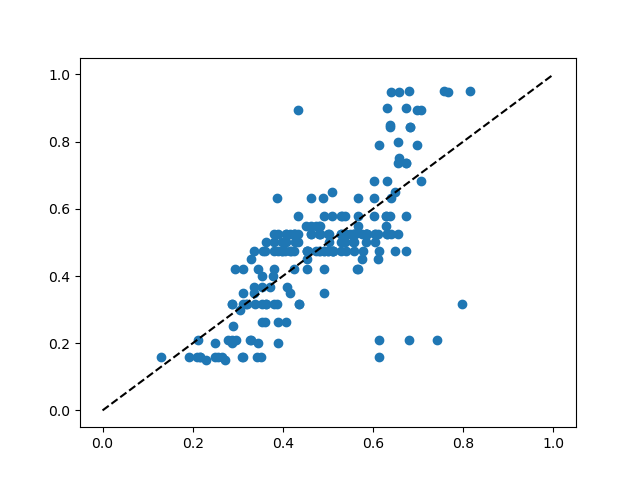

<IPython.core.display.Javascript object>


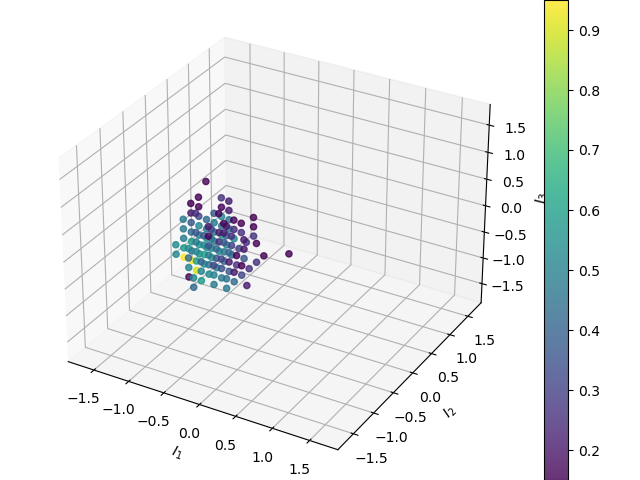

/tmp/ipykernel_9008/354451011.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[-5.14270148 -2.13086573 -1.04289936 -1.67252258]
0.904809451683884


<IPython.core.display.Javascript object>


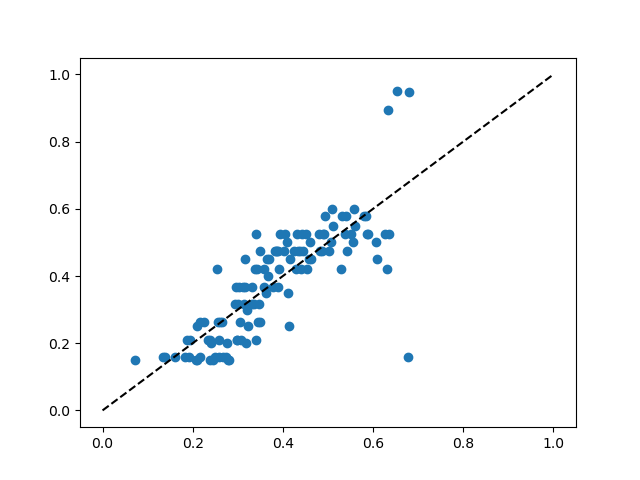

<IPython.core.display.Javascript object>


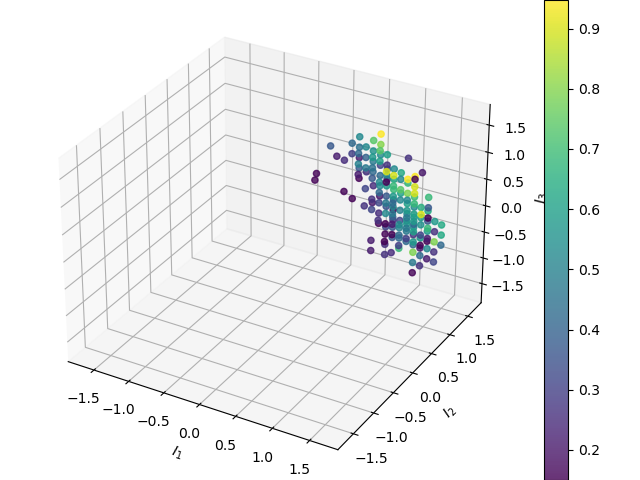

/tmp/ipykernel_9008/354451011.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[-3.91698204  1.62872049  1.48005302  1.06164631]
0.9466816411652862


<IPython.core.display.Javascript object>


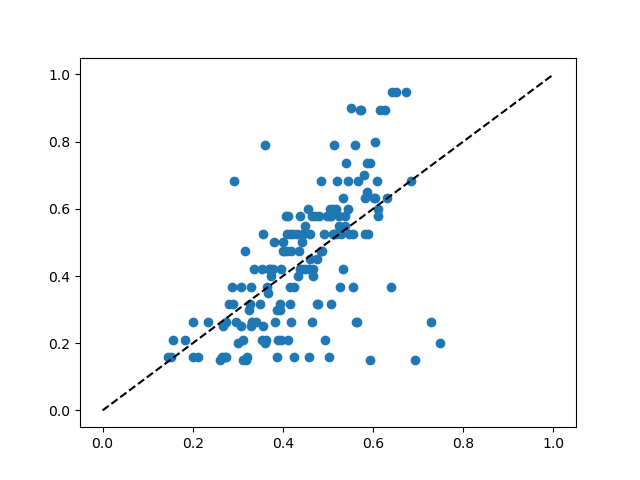

<IPython.core.display.Javascript object>


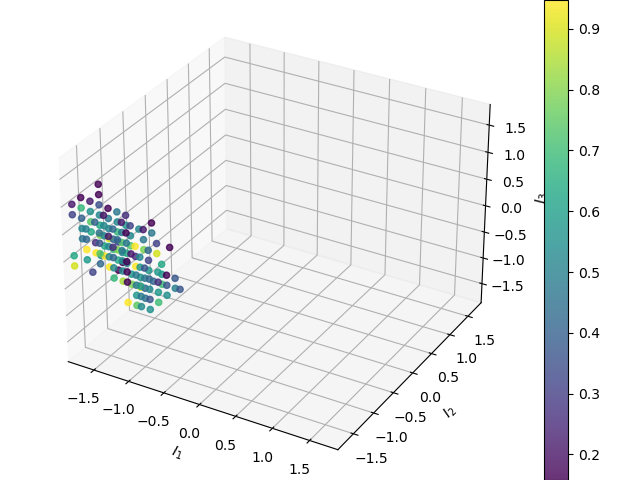

/tmp/ipykernel_9008/354451011.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[-3.67633221 -1.70166669 -1.00482747 -1.78934821]
0.9609144737308272


<IPython.core.display.Javascript object>


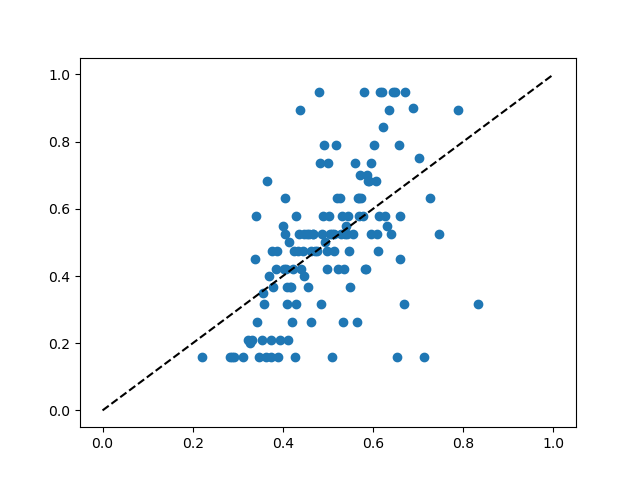

<IPython.core.display.Javascript object>


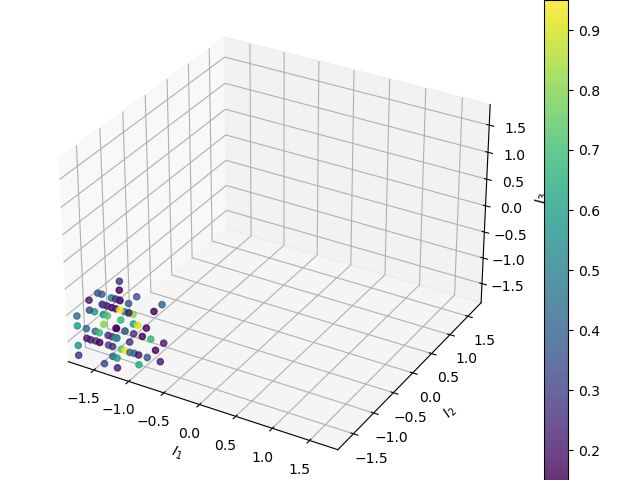

/tmp/ipykernel_9008/354451011.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[-1.8010283  -0.51528576  0.09150523 -0.51727381]
0.9616879240526117


<IPython.core.display.Javascript object>


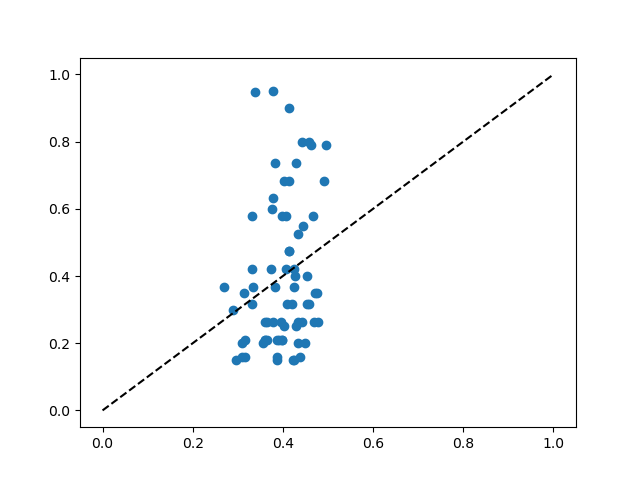

<IPython.core.display.Javascript object>


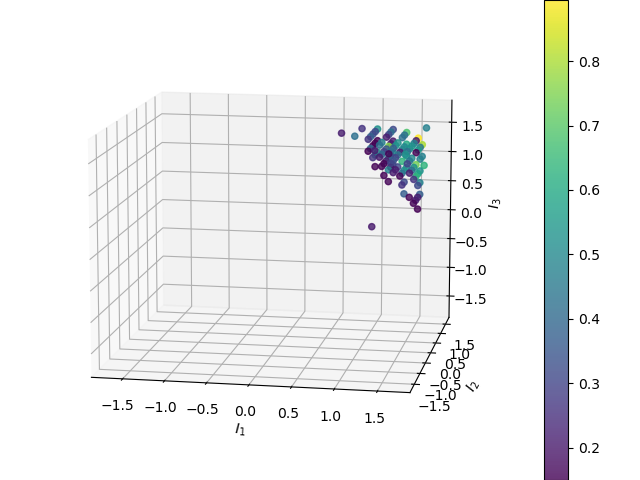

/tmp/ipykernel_9008/354451011.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[-4.724119    1.97611853  0.66135138  1.10133812]
0.9224808505287909


<IPython.core.display.Javascript object>


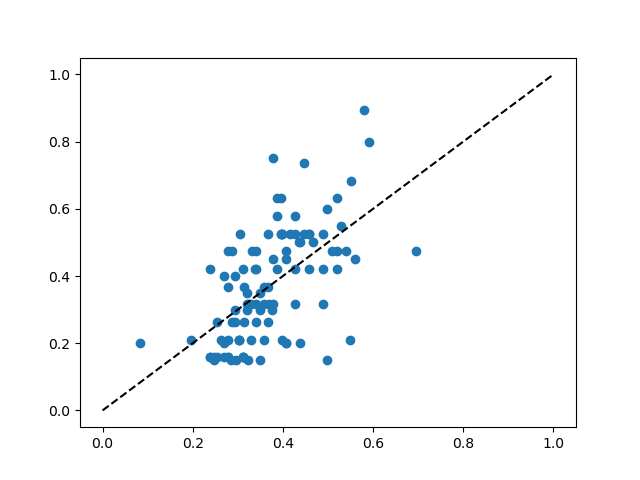

<IPython.core.display.Javascript object>


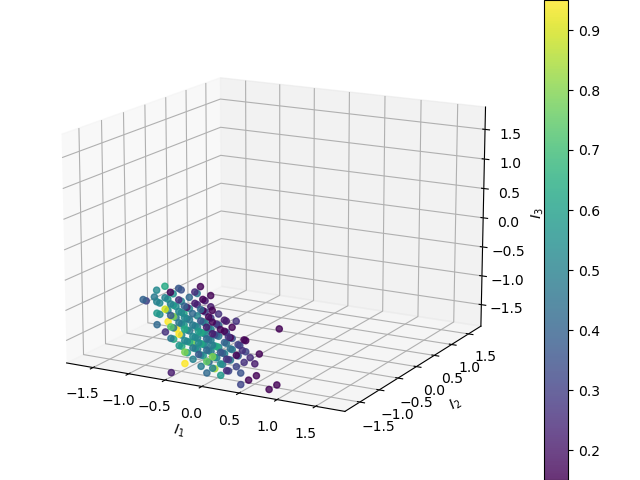

/tmp/ipykernel_9008/354451011.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[-4.13409999 -1.9181738  -1.21011463 -1.30418293]
0.9403506572685438


<IPython.core.display.Javascript object>


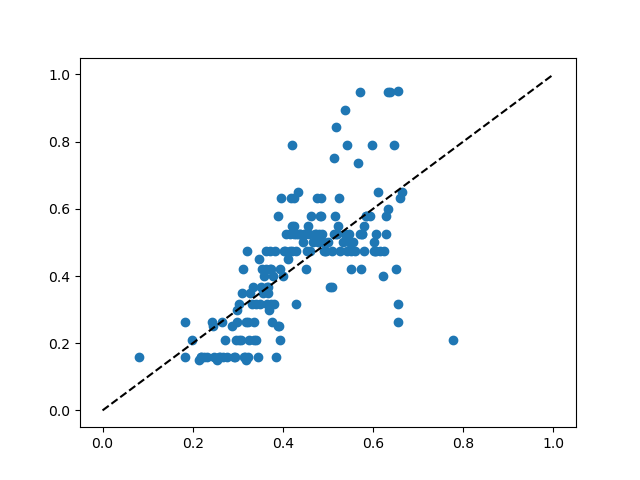

<IPython.core.display.Javascript object>


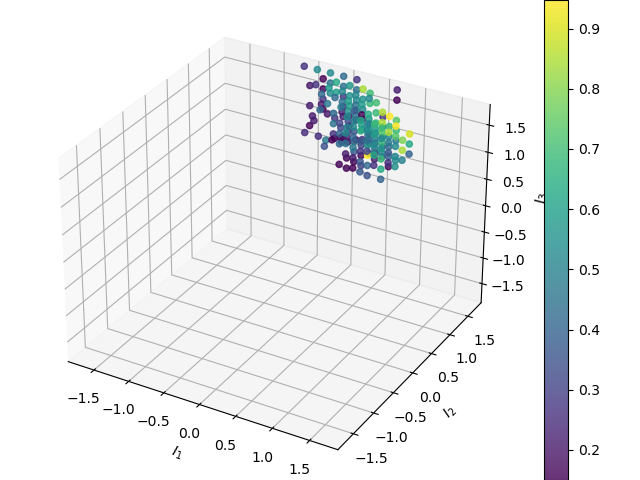

/tmp/ipykernel_9008/354451011.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[-4.19099045  1.86445561  1.1587205   1.28837027]
0.9355572285233429


<IPython.core.display.Javascript object>


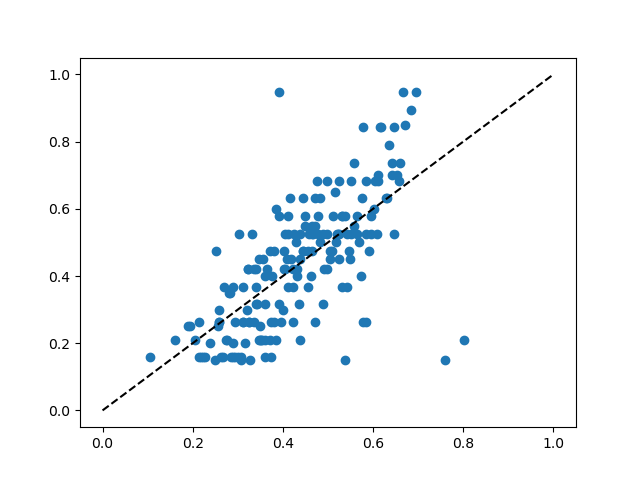

<IPython.core.display.Javascript object>


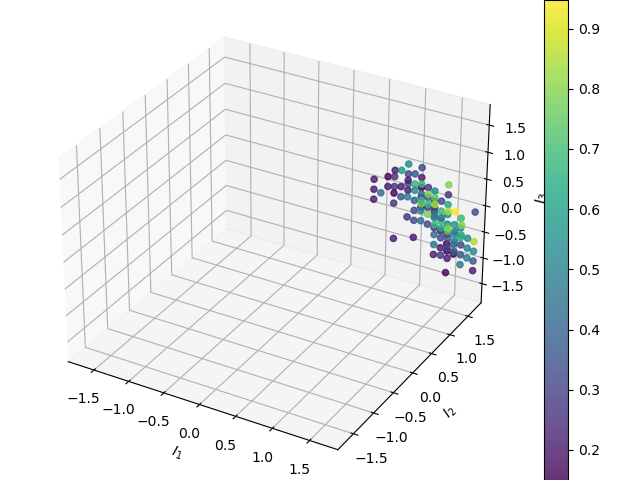

/tmp/ipykernel_9008/354451011.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[-4.82368444  2.31790957  1.01754476  1.58963058]
0.9299275467638186


<IPython.core.display.Javascript object>


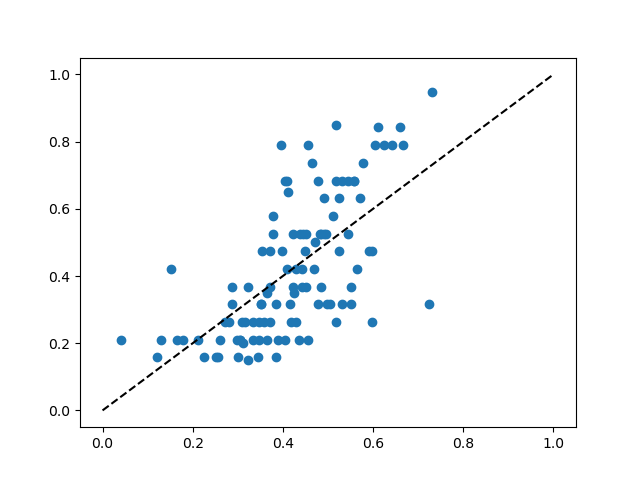

In [63]:
nt_weights = []
nt_amps = []
nt_probs = []
for nt in nontargets:
    print(vcd.get_cell_type_for_cell(nt))
    weights, amps, probs = getWeights(p, nt, clusters_nt, negll_thr, show_clusters=True)
    nt_weights.append(weights)
    nt_amps.append(amps)
    nt_probs.append(probs)

nt_weights = np.vstack((nt_weights))

In [64]:
nt_weights

array([[-4.91219967, -2.22459139, -1.6116693 , -1.62300892],
       [-5.14270148, -2.13086573, -1.04289936, -1.67252258],
       [-3.91698204,  1.62872049,  1.48005302,  1.06164631],
       [-4.724119  ,  1.97611853,  0.66135138,  1.10133812],
       [-4.13409999, -1.9181738 , -1.21011463, -1.30418293],
       [-4.19099045,  1.86445561,  1.1587205 ,  1.28837027],
       [-4.82368444,  2.31790957,  1.01754476,  1.58963058]])

ON parasol


<IPython.core.display.Javascript object>


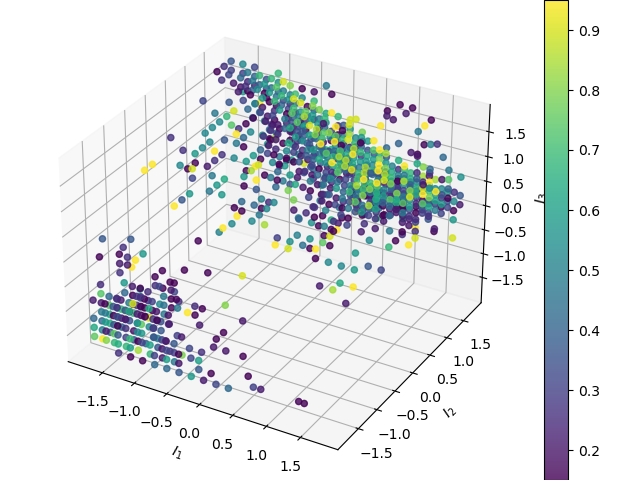

/tmp/ipykernel_9008/354451011.py:23: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


<IPython.core.display.Javascript object>


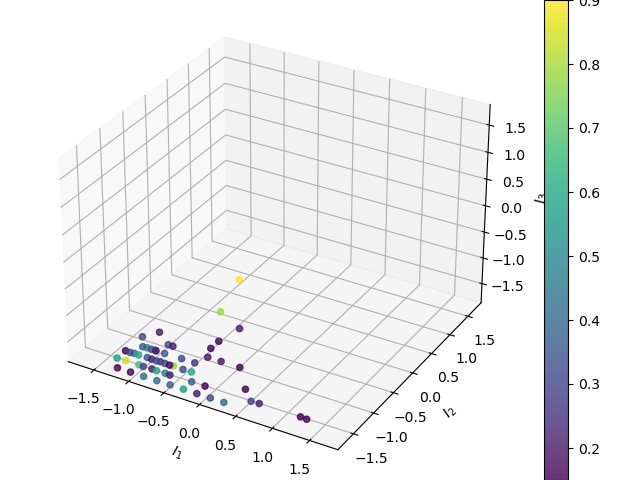

[ 0.58912769 -0.39360609  0.05366191  0.85604883]
0.91396575194574


/tmp/ipykernel_9008/354451011.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


<IPython.core.display.Javascript object>


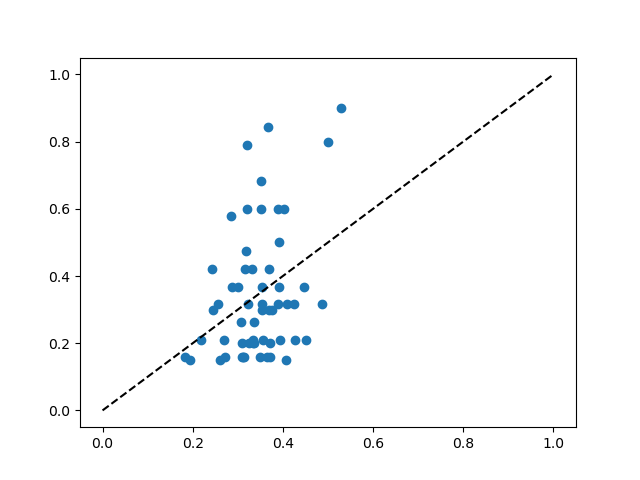

<IPython.core.display.Javascript object>


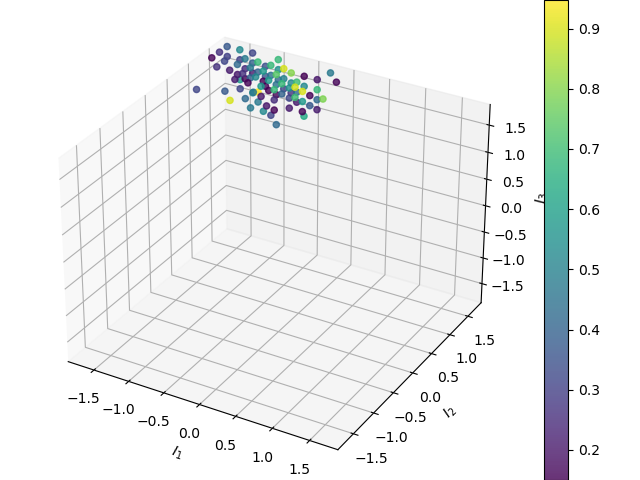

[-1.1466856   0.41533577  0.4377627   0.39684974]
0.9768104135509148


/tmp/ipykernel_9008/354451011.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


<IPython.core.display.Javascript object>


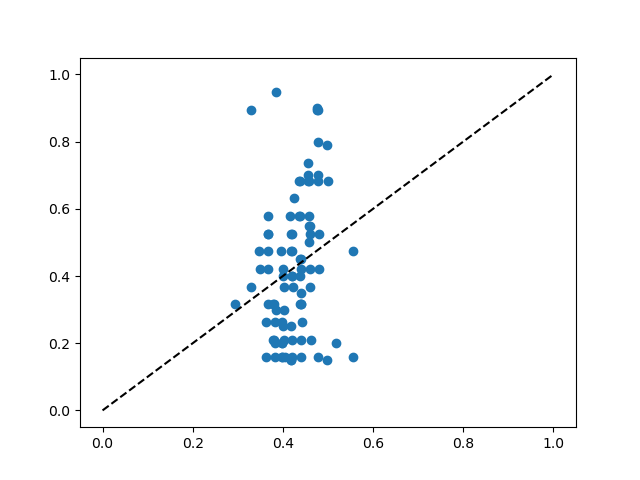

<IPython.core.display.Javascript object>


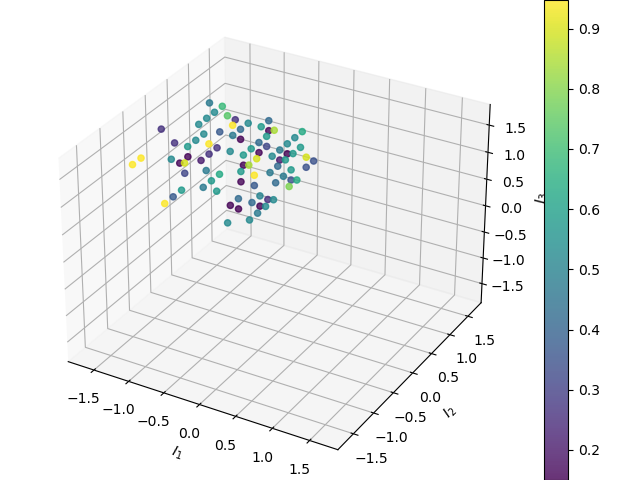

/tmp/ipykernel_9008/354451011.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[-6.64415515  2.6981411   0.41865624  8.52905417]
0.9060763195175522


<IPython.core.display.Javascript object>


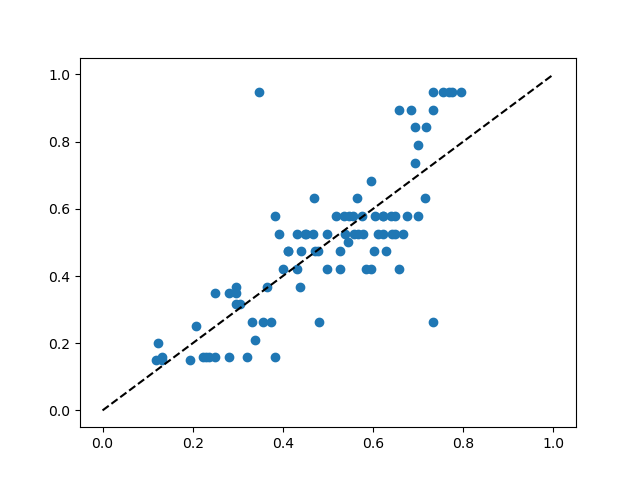

<IPython.core.display.Javascript object>


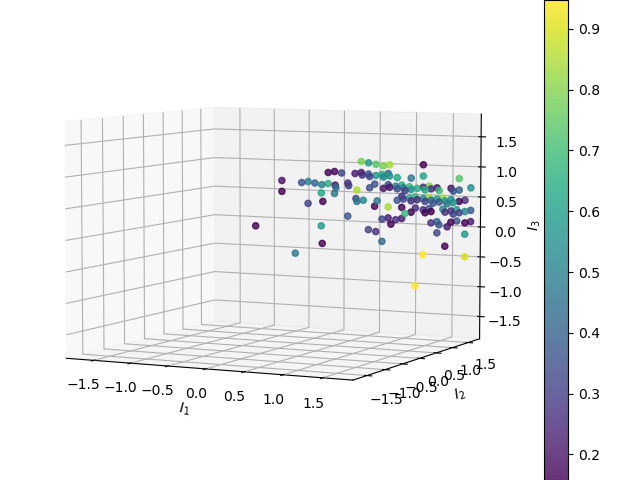

/tmp/ipykernel_9008/354451011.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[-1.02421265  0.17221889  0.28639066  0.24361939]
0.9772430927420537


<IPython.core.display.Javascript object>


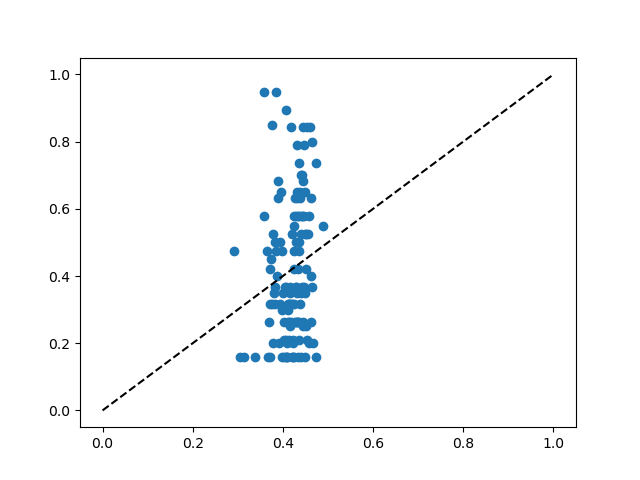

<IPython.core.display.Javascript object>


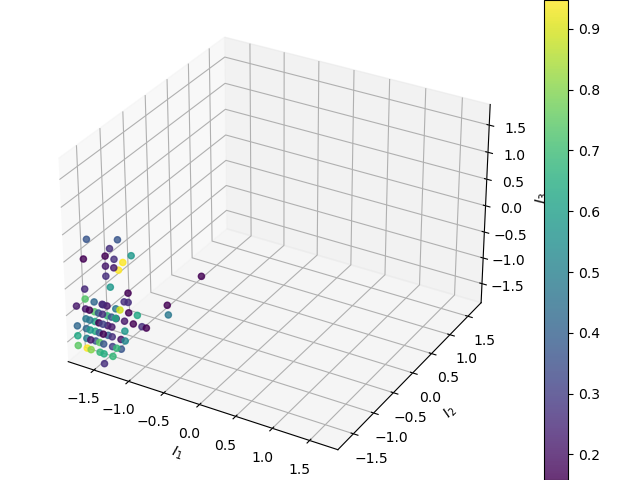

/tmp/ipykernel_9008/354451011.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[-1.89898224 -0.52429995 -0.25935199 -0.34418282]
0.9667111905593607


<IPython.core.display.Javascript object>


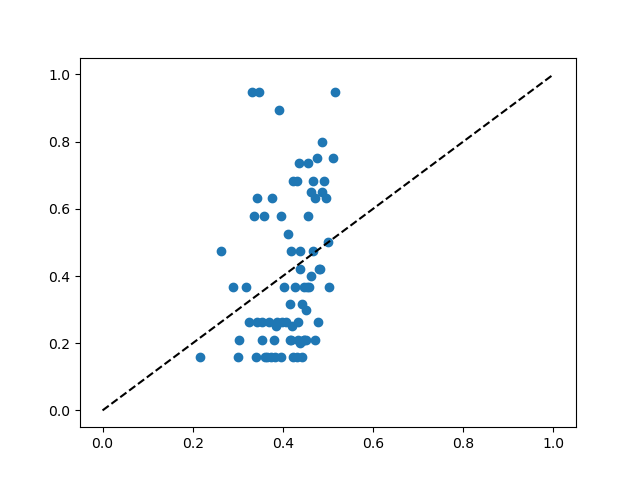

<IPython.core.display.Javascript object>


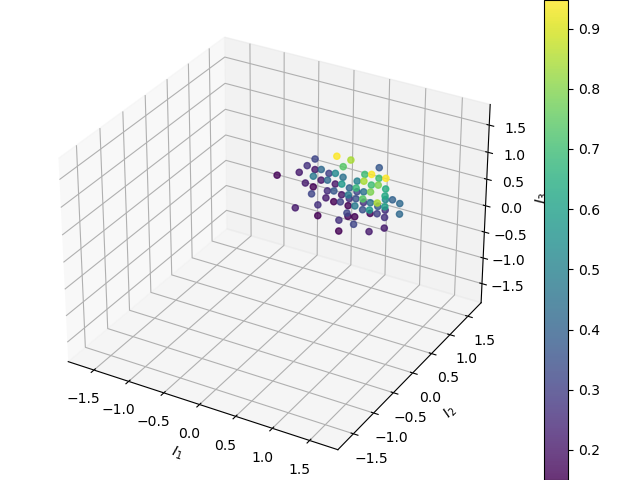

[-9.78700671  1.8952249   2.40735623  5.12780591]
0.8586960089556995


/tmp/ipykernel_9008/354451011.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


<IPython.core.display.Javascript object>


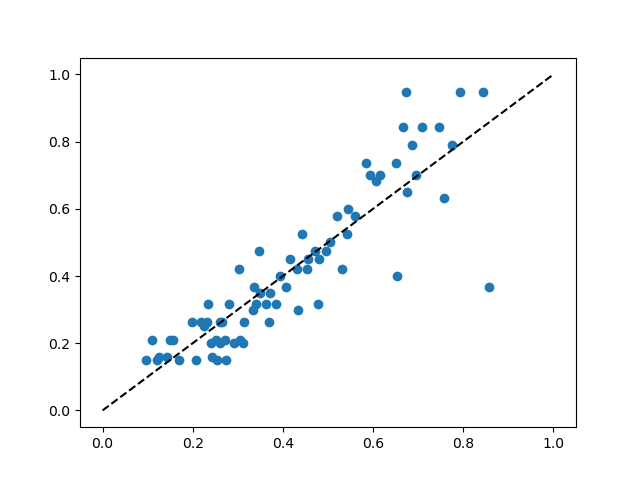

<IPython.core.display.Javascript object>


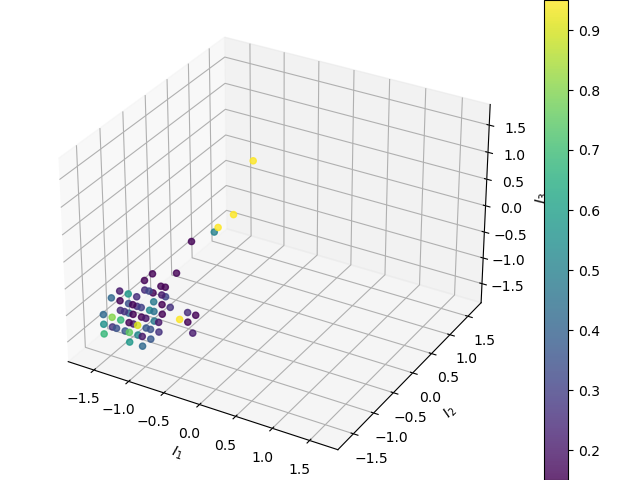

[ 2.62411483  0.4715975  -0.23279029  1.65338763]
0.9142621284174023


/tmp/ipykernel_9008/354451011.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


<IPython.core.display.Javascript object>


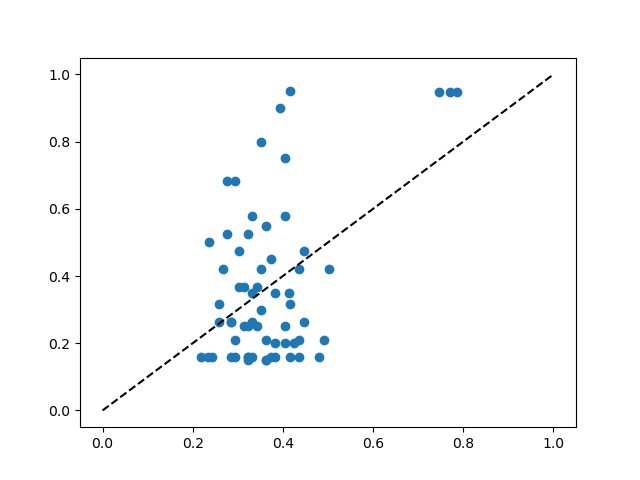

<IPython.core.display.Javascript object>


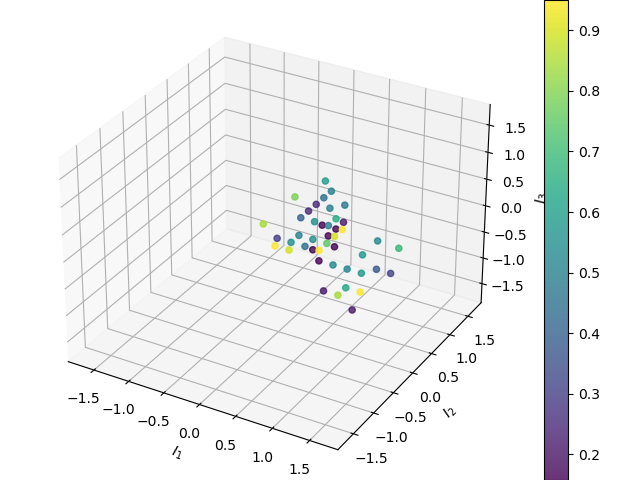

[-9.86962906  3.68887478  0.82497207 11.99820767]
0.8591682834503666


/tmp/ipykernel_9008/354451011.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


<IPython.core.display.Javascript object>


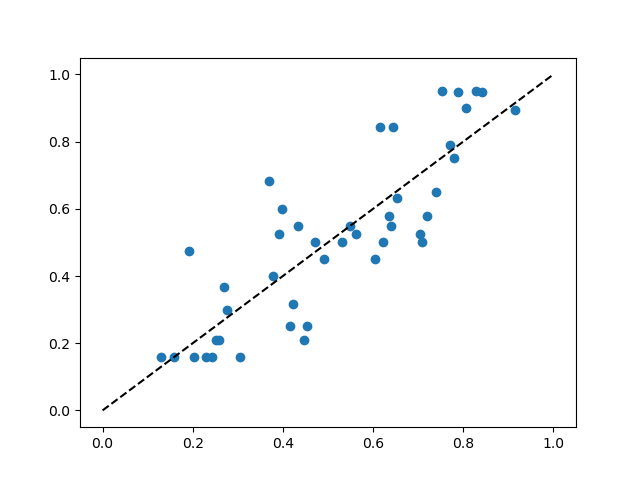

<IPython.core.display.Javascript object>


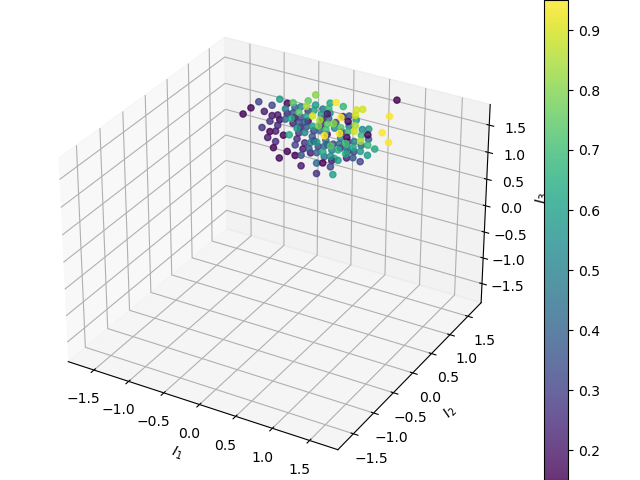

/tmp/ipykernel_9008/354451011.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[-5.68939738  1.74596343  1.66958753  2.7515581 ]
0.9212695145525767


<IPython.core.display.Javascript object>


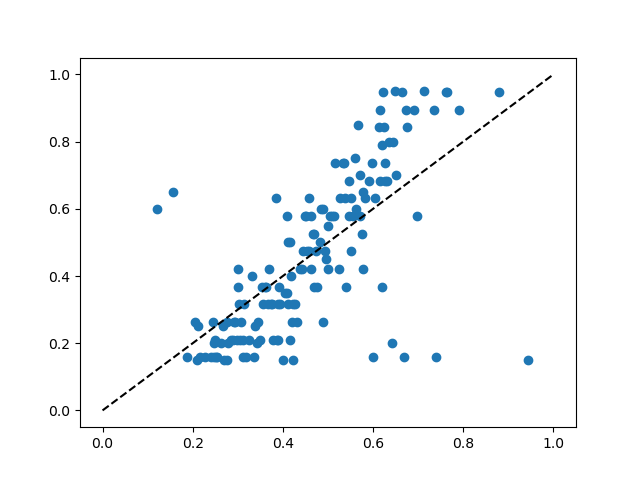

<IPython.core.display.Javascript object>


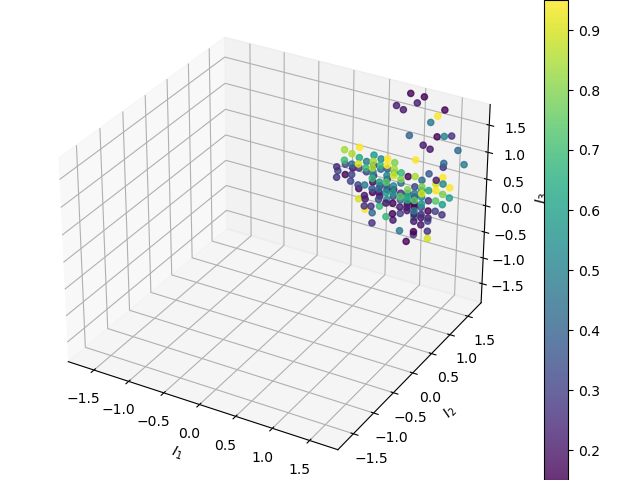

/tmp/ipykernel_9008/354451011.py:49: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[-0.9600388   0.23990084 -0.08630028  0.48534823]
0.9868821311470773


<IPython.core.display.Javascript object>


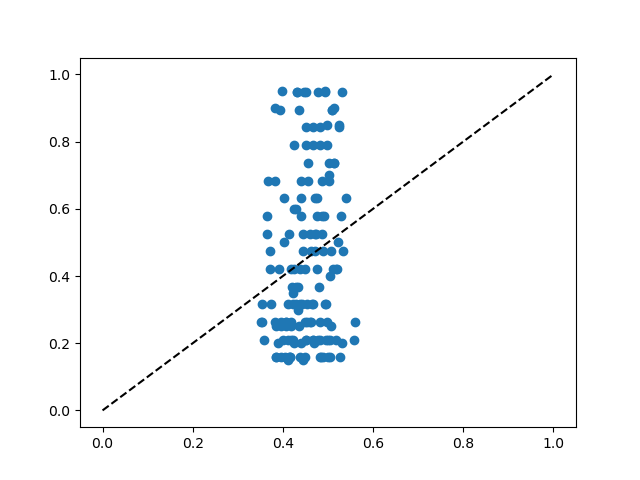

In [67]:
t_weights = []
t_amps = []
t_probs = []
for t in targets:
    print(vcd.get_cell_type_for_cell(t))
    weights, amps, probs = getWeights(p, t, clusters_t, 98, show_clusters=True)
    t_weights.append(weights)
    t_amps.append(amps)
    t_probs.append(probs)

t_weights = np.vstack((t_weights))

In [68]:
t_weights

array([[-1.1466856 ,  0.41533577,  0.4377627 ,  0.39684974],
       [-6.64415515,  2.6981411 ,  0.41865624,  8.52905417],
       [-1.02421265,  0.17221889,  0.28639066,  0.24361939],
       [-1.89898224, -0.52429995, -0.25935199, -0.34418282],
       [-9.78700671,  1.8952249 ,  2.40735623,  5.12780591],
       [-9.86962906,  3.68887478,  0.82497207, 11.99820767],
       [-5.68939738,  1.74596343,  1.66958753,  2.7515581 ],
       [-0.9600388 ,  0.23990084, -0.08630028,  0.48534823]])

In [69]:
def compute_pt(T):
    return 1/(np.exp(T)+1)

def compute_pn(T):
    return np.exp(T)/(np.exp(T)+1)

In [70]:
I_max = 1.78125
selec_vals = np.zeros(len(t_weights))
x_vals = np.zeros((len(t_weights), 3))
for i in range(len(t_weights)):
    print(i)
    T_t = cp.Variable(1)
    T_n = cp.Variable(1)
    x = cp.Variable(3)

    constraints = [
        -t_weights[i, 0] - t_weights[i,1:] @ x  <= T_t,
        nt_weights[:, 0] + nt_weights[:, 1:] @ x <= T_n,
        x <= I_max,
        -I_max <= x, 
    ]

    objective_function = cp.exp(T_n) + cp.exp(T_t)

    objective = cp.Minimize(objective_function)
    prob = cp.Problem(objective, constraints)
    opt_val  = prob.solve()
    print(f"Optimal value {opt_val}")

    print(f"optimal p_t {compute_pt(T_t.value)[0]}")
    print(f"optimal p_n {compute_pn(T_n.value)[0]}")
    print(f"optimal T_t {T_t.value[0]}")
    print(f"optimal T_n {T_n.value[0]}")
    print(x.value)

    selec_vals[i] = compute_pt(T_t.value)[0] * (1 - compute_pn(T_n.value)[0])
    x_vals[i] = x.value

0
Optimal value 1.4303783679793063
optimal p_t 0.46734712820847757
optimal p_n 0.22519134993737616
optimal T_t 0.13079764279111844
optimal T_n -1.2356656107749506
[-1.13345751  1.78124998  1.78124999]
1
Optimal value 0.01680396955538096
optimal p_t 0.9992662873590945
optimal p_n 0.015815566488556785
optimal T_t -7.216659121469155
optimal T_n -4.130818636103135
[-0.2588875  -1.5120583   1.78124894]
2
Optimal value 1.5623789714919547
optimal p_t 0.41442621414774716
optimal p_n 0.12998403756105179
optimal T_t 0.3456972500254689
optimal T_n -1.901099904186678
[-1.54202013  1.78124999  1.78124999]
3
Optimal value 2.920891885283834
optimal p_t 0.2964253728363668
optimal p_n 0.35373860915333316
optimal T_t 0.8643784576432303
optimal T_n -0.6026458035699003
[-1.78124999  1.17359977 -1.17690343]
4
Optimal value 0.51609102956385
optimal p_t 0.8074085516947439
optimal p_n 0.21725831128469109
optimal T_t -1.4332587029528572
optimal T_n -1.2817157219021962
[-1.16173132  1.78124999  1.78125   ]
5
Op

In [71]:
selec_vals

array([0.3621046 , 0.98346232, 0.36055742, 0.19156827, 0.63199233,
       0.98409448, 0.45829388, 0.50604042])

In [72]:
selec_vals[np.argsort(selec_vals)]

array([0.19156827, 0.36055742, 0.3621046 , 0.45829388, 0.50604042,
       0.63199233, 0.98346232, 0.98409448])

In [73]:
x_vals[np.argsort(selec_vals)]

array([[-1.78124999,  1.17359977, -1.17690343],
       [-1.54202013,  1.78124999,  1.78124999],
       [-1.13345751,  1.78124998,  1.78124999],
       [-0.80797969,  1.78124992,  1.78124999],
       [ 0.57793606, -1.78124999,  1.78125   ],
       [-1.16173132,  1.78124999,  1.78125   ],
       [-0.2588875 , -1.5120583 ,  1.78124894],
       [-0.27937276, -1.47934148,  1.78124412]])

In [92]:
selec_vec = x_vals[np.argsort(selec_vals)[-5]]

<IPython.core.display.Javascript object>


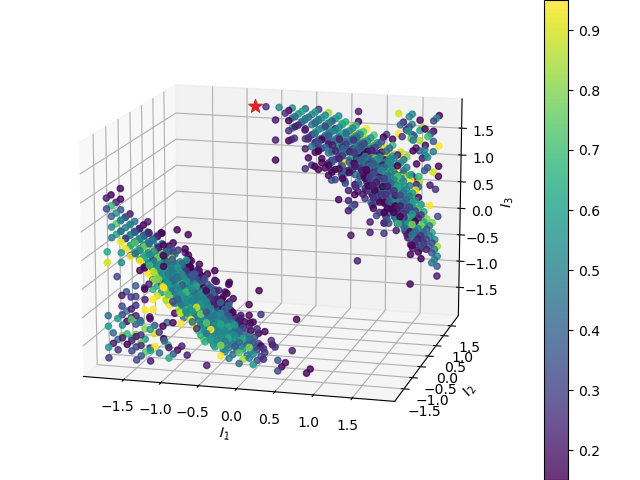

/tmp/ipykernel_9008/354451011.py:23: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
/Volumes/Lab/Development/miniconda-peggyo/envs/pvasi39/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


[ 2.30320794 -1.21764343 -0.28457971 -0.09065462]
0.9762941173646846
[-4.91219967 -2.22459139 -1.6116693  -1.62300892]
0.9437529675594162
[-5.14270148 -2.13086573 -1.04289936 -1.67252258]
0.904809451683884
[-3.91698204  1.62872049  1.48005302  1.06164631]
0.9466816411652862
[-3.67633221 -1.70166669 -1.00482747 -1.78934821]
0.9609144737308272
[-1.8010283  -0.51528576  0.09150523 -0.51727381]
0.9616879240526117
[-4.724119    1.97611853  0.66135138  1.10133812]
0.9224808505287909
[-4.13409999 -1.9181738  -1.21011463 -1.30418293]
0.9403506572685438
[-4.19099045  1.86445561  1.1587205   1.28837027]
0.9355572285233429
[-4.82368444  2.31790957  1.01754476  1.58963058]
0.9299275467638186


In [93]:
for nt in nontargets:
    getWeights(p, nt, clusters_nt, negll_thr, selec_vec=selec_vec, show_clusters=False)

<IPython.core.display.Javascript object>


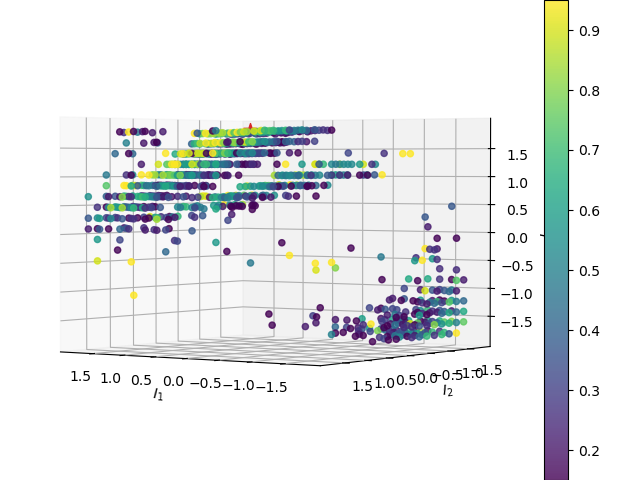

/tmp/ipykernel_9008/354451011.py:23: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


[ 0.58912769 -0.39360609  0.05366191  0.85604883]
0.91396575194574
[-1.1466856   0.41533577  0.4377627   0.39684974]
0.9768104135509148
[-6.64415515  2.6981411   0.41865624  8.52905417]
0.9060763195175522
[-1.02421265  0.17221889  0.28639066  0.24361939]
0.9772430927420537
[-1.89898224 -0.52429995 -0.25935199 -0.34418282]
0.9667111905593607
[-9.78700671  1.8952249   2.40735623  5.12780591]
0.8586960089556995
[ 2.62411483  0.4715975  -0.23279029  1.65338763]
0.9142621284174023
[-9.86962906  3.68887478  0.82497207 11.99820767]
0.8591682834503666
[-5.68939738  1.74596343  1.66958753  2.7515581 ]
0.9212695145525767
[-0.9600388   0.23990084 -0.08630028  0.48534823]
0.9868821311470773


In [94]:
for t in targets:
    getWeights(p, t, clusters_t, negll_thr, selec_vec=selec_vec, show_clusters=False)

In [49]:
current_levels = np.arange(-19, 20, 2) * 3/128 * 4

In [50]:
current_levels

array([-1.78125, -1.59375, -1.40625, -1.21875, -1.03125, -0.84375,
       -0.65625, -0.46875, -0.28125, -0.09375,  0.09375,  0.28125,
        0.46875,  0.65625,  0.84375,  1.03125,  1.21875,  1.40625,
        1.59375,  1.78125])

<IPython.core.display.Javascript object>


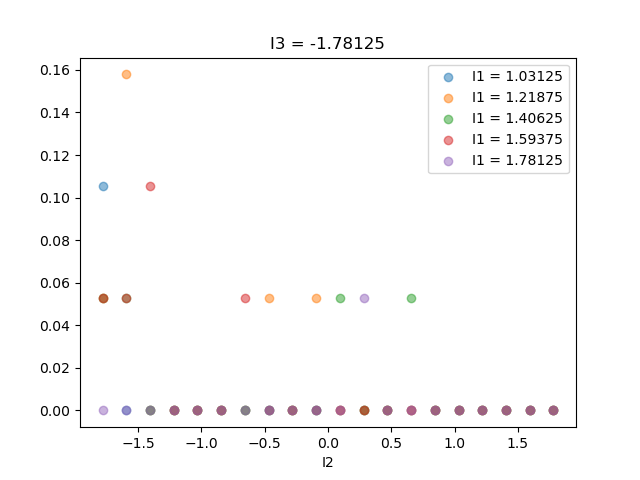

In [51]:
# I1 = 1.21875
I3 = -1.78125

plt.figure()
plt.title('I3 = ' + str(I3))
plt.xlabel('I2')

for I1 in current_levels[-5:]:
    inds = np.where((t_amps[0][:, 0] == I1) & (t_amps[0][:, 2] == I3))[0]
    plt.scatter(t_amps[0][inds][:, 1], t_probs[0][inds], label='I1 = ' + str(I1), alpha=0.5)
    
plt.legend()

In [ ]:
# I1 = 1.21875
I3 = -1.78125

plt.figure()
plt.title('I3 = ' + str(I3))
plt.xlabel('I2')

for I1 in current_levels[-5:]:
    inds = np.where((nt_amps[0][:, 0] == I1) & (nt_amps[0][:, 2] == I3))[0]
    plt.scatter(nt_amps[0][inds][:, 1], nt_probs[0][inds], label='I1 = ' + str(I1), alpha=0.5)
    
plt.legend()